# Импорти и глобални параметри

In [6]:
from dask import dataframe as dd
from datetime import datetime
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import pandas_alive

In [27]:
plt.style.use('style.mplstyle')

In [8]:
SAVE_FILES = True

In [9]:
def parse_timestamp(timestamp, date_format):
    timestamp /= 1000
    timestamp = int(timestamp)
    timestamp += 1648806250

    dt = datetime.fromtimestamp(timestamp).strftime(date_format)
    dt = datetime.strptime(dt, date_format)

    return dt

In [66]:
def millions(x, pos):
    return '%1.1f' % (x * 1e-6)

formatter = FuncFormatter(millions)

# Импортиране на файлове

In [11]:
ddf_users = dd.read_csv('data\\raw\\2022_place_canvas_history_users.csv')
ddf_users.head()

,user_id
0,ovTZk4GyTS1mDQnTbV+vDOCu1f+u6w+CkIZ6445vD4XN8a...
1,6NSgFa1CvIPly1VniNhlbrmoN3vgDFbMSKqh+c4TTfrr3d...
2,O5Oityp3Z3owzTuwM9XnMggpLcqKEumsOMKGhRiDTTImWb...
3,tc273UiqS0wKa6VwiOs/iz/t4LyPYrhL2Q347awn11IQQE...
4,OOWsU/HLb4UUkQwclDeXFtsJTOXMlAdNHiRpFA1Qk+SxUr...


In [12]:
ddf_main = dd.read_csv('data\\raw\\2022_place_canvas_history_core.csv')
ddf_main.head()

,timestamp,pixel_color,coordinate
0,0,#7EED56,"42,42"
1,12356,#00A368,"999,999"
2,16311,#3690EA,"44,42"
3,21388,#D4D7D9,"2,2"
4,34094,#3690EA,"23,23"


In [13]:
ddf_date = dd.read_csv('data\\raw\\2022_place_canvas_history_datetime.csv')
ddf_date.head()

,datetime
0,2022-04-01 12:00:00
1,2022-04-01 12:00:00
2,2022-04-01 12:00:00
3,2022-04-01 12:00:00
4,2022-04-01 12:00:00


In [14]:
ddf_pivoted = dd.read_csv('data\\raw\\2022_place_canvas_history_pivoted.csv')
ddf_pivoted.head()

,datetime,#000000,#00A368,#2450A4,#3690EA,#51E9F4,#7EED56,#811E9F,#898D90,#9C6926,...,#BE0039,#FF3881,#00CCC0,#515252,#6D001A,#94B3FF,#DE107F,#E4ABFF,#FFB470,#FFF8B8
0,2022-04-01 12:00:00,0,2,3,2,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-04-01 13:00:00,117511,21775,83172,15056,24328,21971,19421,7081,6169,...,0,0,0,0,0,0,0,0,0,0
2,2022-04-01 14:00:00,198737,33085,115221,20169,38124,30806,26811,12597,9609,...,0,0,0,0,0,0,0,0,0,0
3,2022-04-01 15:00:00,242980,35452,98686,25440,42816,33479,27869,17086,12235,...,0,0,0,0,0,0,0,0,0,0
4,2022-04-01 16:00:00,246588,40658,99270,29857,49147,37166,32077,20787,11657,...,0,0,0,0,0,0,0,0,0,0


# Диаграми

### Стълбовидна диаграма, представяща 20-те най-активни потребители

In [15]:
all_users = ddf_users.user_id.value_counts().compute().reset_index(name='num_placed_pixels')

In [16]:
most_active_users = all_users.head(20).set_index('index')
most_active_users.head()

,num_placed_pixels
index,
kgZoJz//JpfXgowLxOhcQlFYOCm8m6upa6Rpltcc63K6Cz0vEWJF/RYmlsaXsIQEbXrwz+Il3BkD8XZVx7YMLQ==,795
JMlte6XKe+nnFvxcjT0hHDYYNgiDXZVOkhr6KT60EtJAGaezxc4e/eah6JzTReWNdTH4fLueQ20A4drmfqbqsw==,781
LNbGhj45pAeCvBYQF1dPvwx1zVfVTy8AdRxTSHi0pR9YeabE3sAd3Rz1MbLFT5k14j0+grrVgqYO1/6BA/jBfQ==,777
8USqGo14WuZQLG7PSAwqfFwICkU0G4VyHZTuV8D1QSbQHE5GFdC2mIK/pMEC/qF1FQH912SDim3ptEFkYPrYMQ==,767
K54RRTUCFuOU55RzSTkjo/ftbJqVi9miyt52YV6NlENRfUyJTPJKBC47N/s2eh4iNdAKMKxa3gvL2XFqCc9AqQ==,767


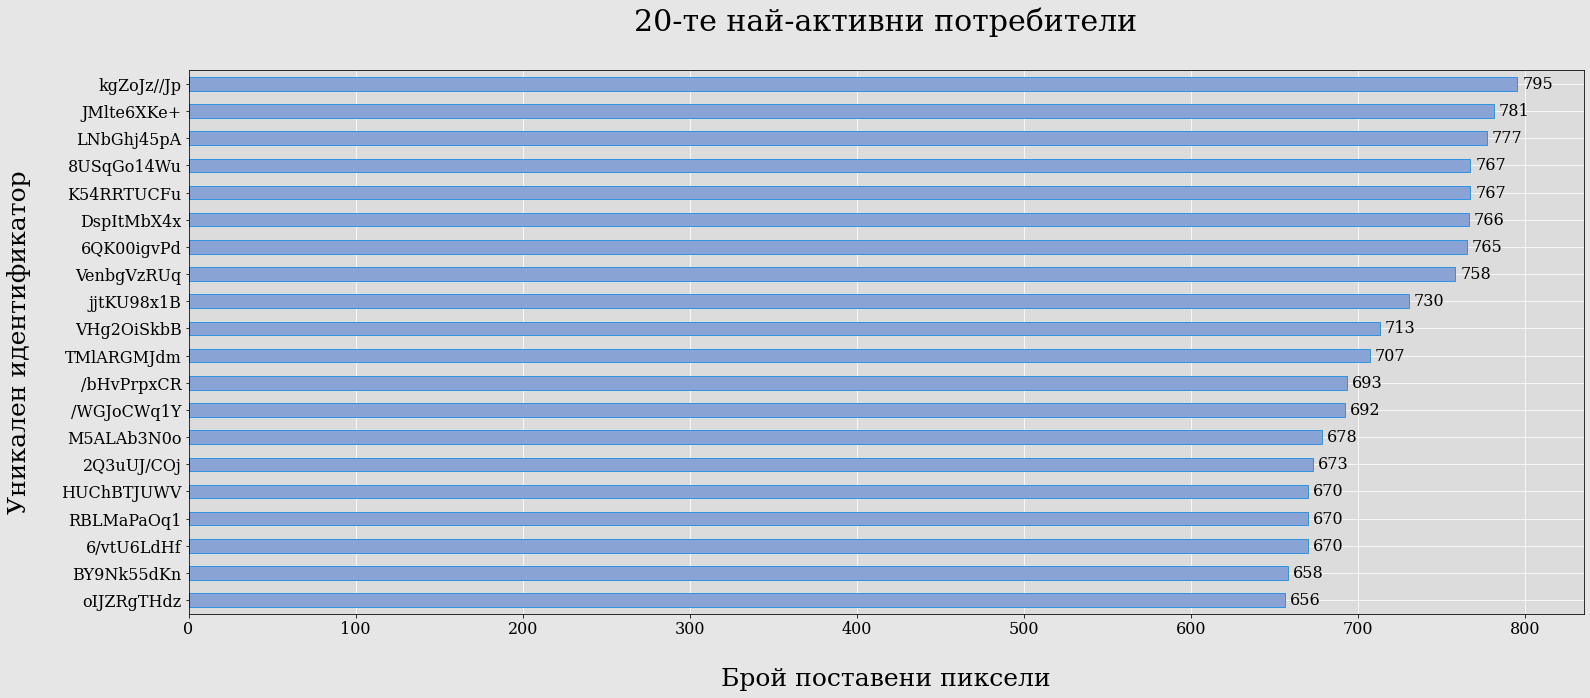

In [28]:
plot = most_active_users.plot(kind='barh', edgecolor='#3193E4')
plot.set_title('20-те най-активни потребители')
plot.set_xlabel('Брой поставени пиксели')
plot.set_ylabel('Уникален идентификатор')

y_tick_labels = []
for label in plot.get_yticklabels():
    y_tick_labels.append(label.get_text()[0:10])

plot.set_yticklabels(y_tick_labels)

bar_labels = plot.containers[0]
plot.axes.bar_label(bar_labels, padding=5, fontsize=16)

plot.invert_yaxis()

plot.get_legend().remove()

In [29]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig = plot.get_figure()
    fig.savefig(f'output\\plot_users-{now}.png')

### Разпръсната диаграма, представяща броя потребители според това колко пиксели са поставили

In [30]:
num_active_users = all_users.num_placed_pixels.value_counts().reset_index(name='users')
num_active_users.head()

,index,users
0,1,2340498
1,2,1175052
2,3,768335
3,4,572021
4,5,460215


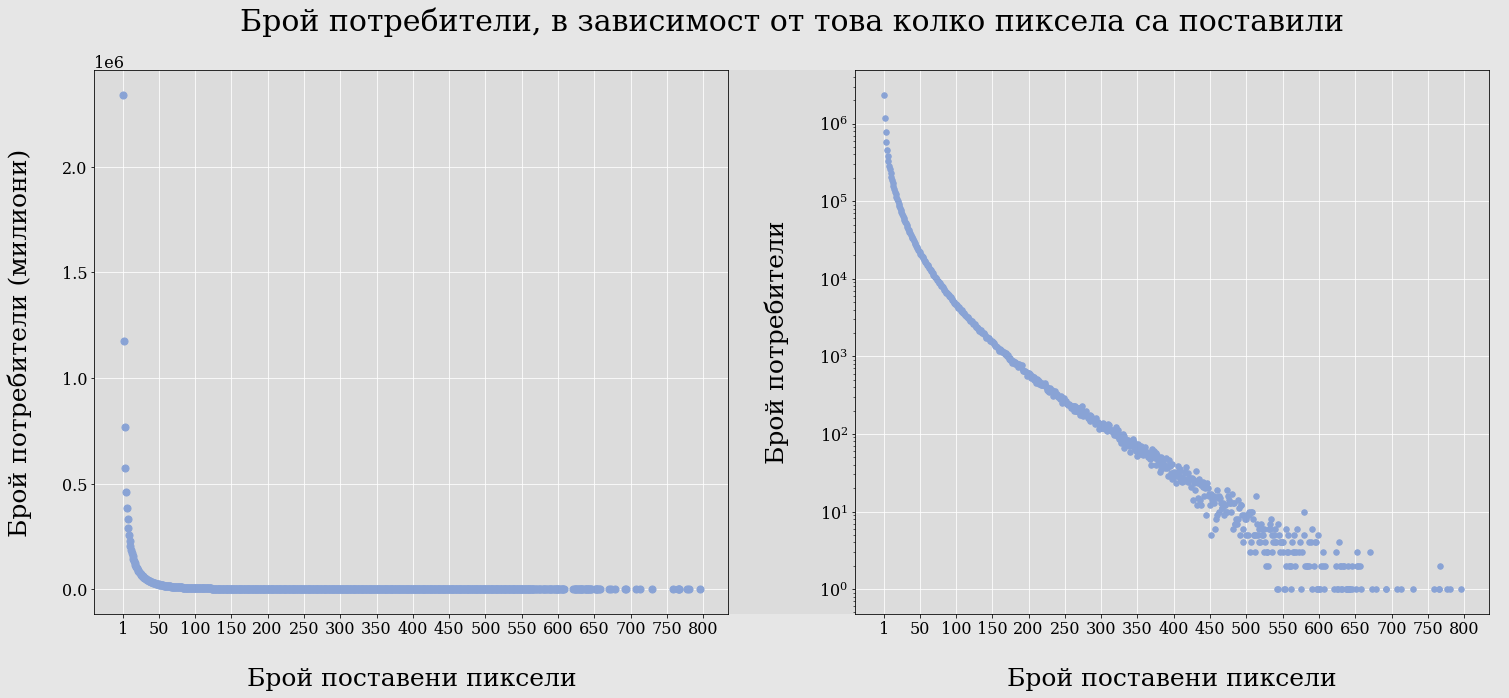

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)    
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='#E6E6E6', top=False, bottom=False, left=False, right=False)
ax.grid(False)

ax.set_title('Брой потребители, в зависимост от това колко пиксела са поставили')

num_active_users.plot(x=0, y=1, kind='scatter', zorder=3, s=50, ax=ax1)

ax1.set_xlabel('Брой поставени пиксели')
ax1.set_ylabel('Брой потребители (милиони)')
ax1.set_xticks([1,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800])

num_active_users.plot(x=0, y=1, kind='scatter', zorder=3, s=30, ax=ax2)

ax2.set_xlabel('Брой поставени пиксели')
ax2.set_ylabel('Брой потребители')
ax2.set_yscale('log')
ax2.set_xticks([1,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800])

In [32]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig.savefig(f'output\\plot_activity-{now}.png')

### Диаграма, представяща броя поставени пиксели от всеки цвят

In [33]:
most_used_colors = ddf_main.pixel_color.value_counts().compute()

most_used_colors.head()

#000000    33707371
#FFFFFF    32251013
#FF4500    14411389
#2450A4     9989854
#FFD635     8519392
Name: pixel_color, dtype: int64

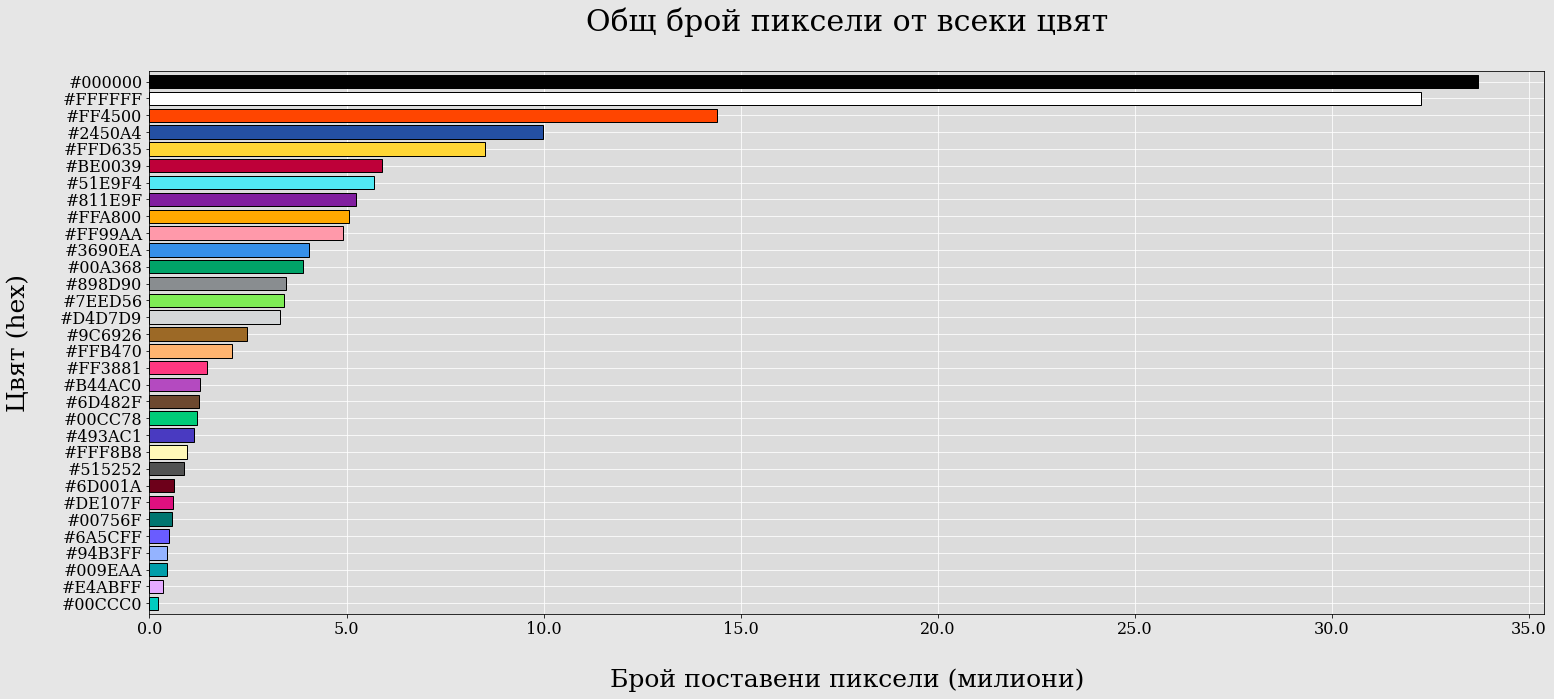

In [34]:
color_bars = []
for color_num in most_used_colors.iteritems():
    color_bars.append(color_num[0])

plot = most_used_colors.plot(kind='barh', color=color_bars, edgecolor='black', zorder=3, width=0.8)

plot.set_title('Общ брой пиксели от всеки цвят')
plot.set_xlabel('Брой поставени пиксели (милиони)')
plot.set_ylabel('Цвят (hex)')

plot.set_yticklabels(color_bars)
plot.xaxis.set_major_formatter(formatter)
    
plot.invert_yaxis()

In [35]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig = plot.get_figure()
    fig.savefig(f'output\\plot_colors-{now}.png')

### Диаграма, преставяща 20-те най-често променяни точки

In [36]:
active_spots = ddf_main.coordinate.value_counts().compute()

In [37]:
top_active_spots = active_spots.head(20)
top_active_spots.head()

0,0        98807
359,564    69198
349,564    55230
859,766    52261
860,766    51485
Name: coordinate, dtype: int64

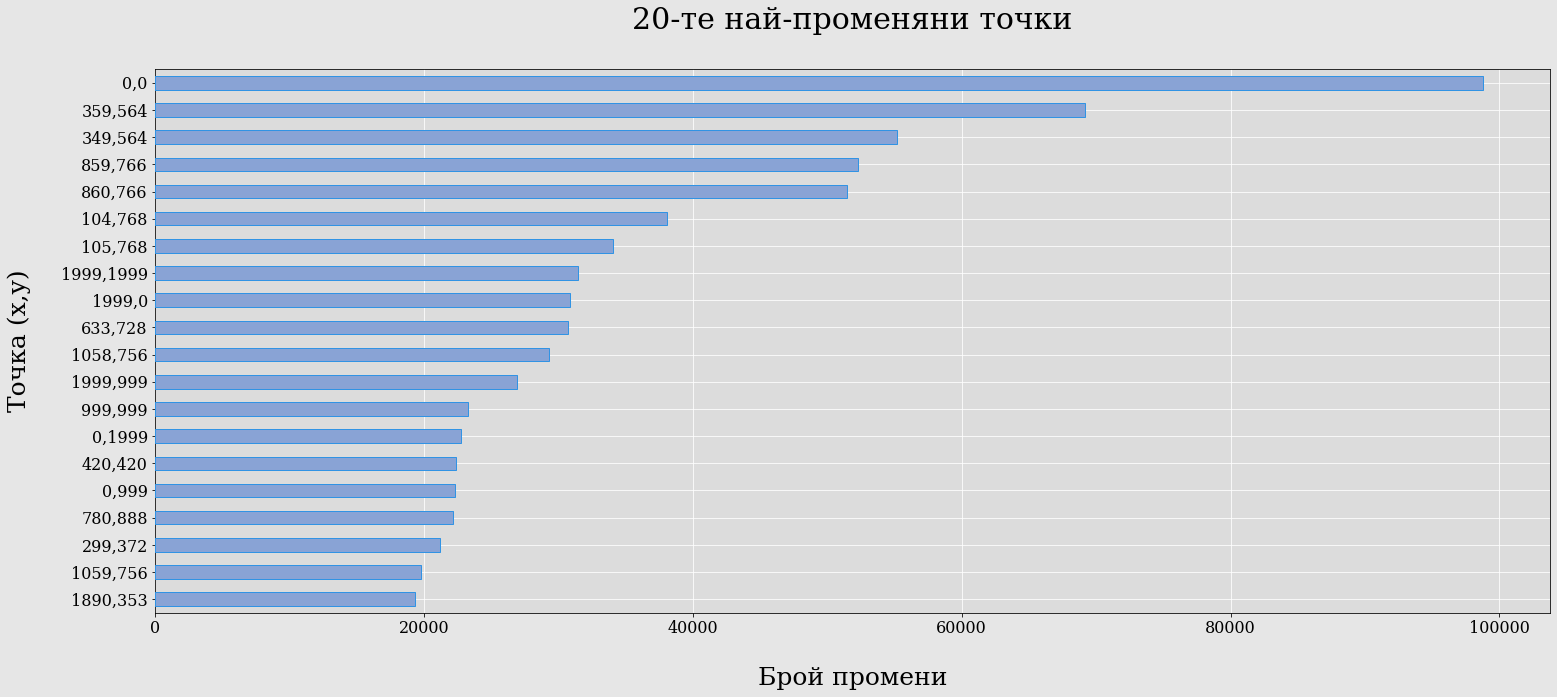

In [38]:
plot = top_active_spots.plot(kind='barh', zorder=3,  edgecolor='#3193E4')

plot.set_title('20-те най-променяни точки')
plot.set_xlabel('Брой промени')
plot.set_ylabel('Точка (x,y)')

plot.invert_yaxis()

In [39]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig = plot.get_figure()
    fig.savefig(f'output\\plot_coordinates-{now}.png')

### Таблица, показваща броя пъти, през които е било нужно цензуриране

In [79]:
ddf_moderated = ddf_main.copy()

ddf_moderated['comma_count'] = ddf_moderated.coordinate.str.count(',')

ddf_moderated.head()

,timestamp,pixel_color,coordinate,comma_count
0,0,#7EED56,"42,42",1
1,12356,#00A368,"999,999",1
2,16311,#3690EA,"44,42",1
3,21388,#D4D7D9,"2,2",1
4,34094,#3690EA,"23,23",1


In [80]:
ddf_moderated = ddf_moderated[ddf_moderated['comma_count'] > 1]
ddf_moderated = ddf_moderated.drop('comma_count', axis=1)
ddf_moderated['timestamp'] = ddf_moderated.apply(lambda x: parse_timestamp(x['timestamp'], '%Y-%m-%d %H%M%S'), axis=1)

ddf_moderated = ddf_moderated.compute()
ddf_moderated = ddf_moderated.set_index('timestamp').reset_index()
 
ddf_moderated.head()

c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\dask\dataframe\core.py:5408: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'datetime64[ns]'))

  warnings.warn(meta_warning(meta))


,timestamp,pixel_color,coordinate
0,2022-04-01 14:44:07,#898D90,"862,540,868,544"
1,2022-04-01 14:46:23,#898D90,"862,540,873,545"
2,2022-04-01 14:46:39,#898D90,"871,546,878,550"
3,2022-04-03 23:03:29,#FFB470,"298,1770,334,1803"
4,2022-04-03 23:05:04,#FFB470,"298,1805,329,1839"


In [81]:
list_coords = ddf_moderated['coordinate'].apply(lambda x: x.split(','))
ddf_moderated = ddf_moderated.drop('coordinate', axis=1)
ddf_moderated = dd.concat([ddf_moderated, list_coords], axis=1)

x1 = []
x2 = []
y1 = []
y2 = []

for coord in ddf_moderated['coordinate']:
    x1.append(int(coord[0]))
    y1.append(int(coord[1]))
    x2.append(int(coord[2]))
    y2.append(int(coord[3]))

ddf_moderated = ddf_moderated.compute()

ddf_moderated['x1'] = x1
ddf_moderated['y1'] = y1
ddf_moderated['x2'] = x2
ddf_moderated['y2'] = y2

ddf_moderated = ddf_moderated.drop('coordinate', axis=1)

ddf_moderated['num_pixels'] = (ddf_moderated['x2'] - ddf_moderated['x1']) * (ddf_moderated['y2'] - ddf_moderated['y1'])

ddf_moderated.head()

,timestamp,pixel_color,x1,y1,x2,y2,num_pixels
0,2022-04-01 14:44:07,#898D90,862,540,868,544,24
1,2022-04-01 14:46:23,#898D90,862,540,873,545,55
2,2022-04-01 14:46:39,#898D90,871,546,878,550,28
3,2022-04-03 23:03:29,#FFB470,298,1770,334,1803,1188
4,2022-04-03 23:05:04,#FFB470,298,1805,329,1839,1054


In [82]:
moderated_count = ddf_moderated['pixel_color'].value_counts()

moderated_count.head()

#898D90    4
#FFB470    4
#000000    4
#FFF8B8    2
#94B3FF    2
Name: pixel_color, dtype: int64

In [83]:
num_moderated_pixels = ddf_moderated.groupby('pixel_color').num_pixels.sum()

num_moderated_pixels.head(19)

pixel_color
#000000    84466
#00CC78      850
#2450A4     1656
#898D90     1705
#94B3FF      377
#B44AC0     2156
#FFB470     8179
#FFF8B8      915
Name: num_pixels, dtype: int64

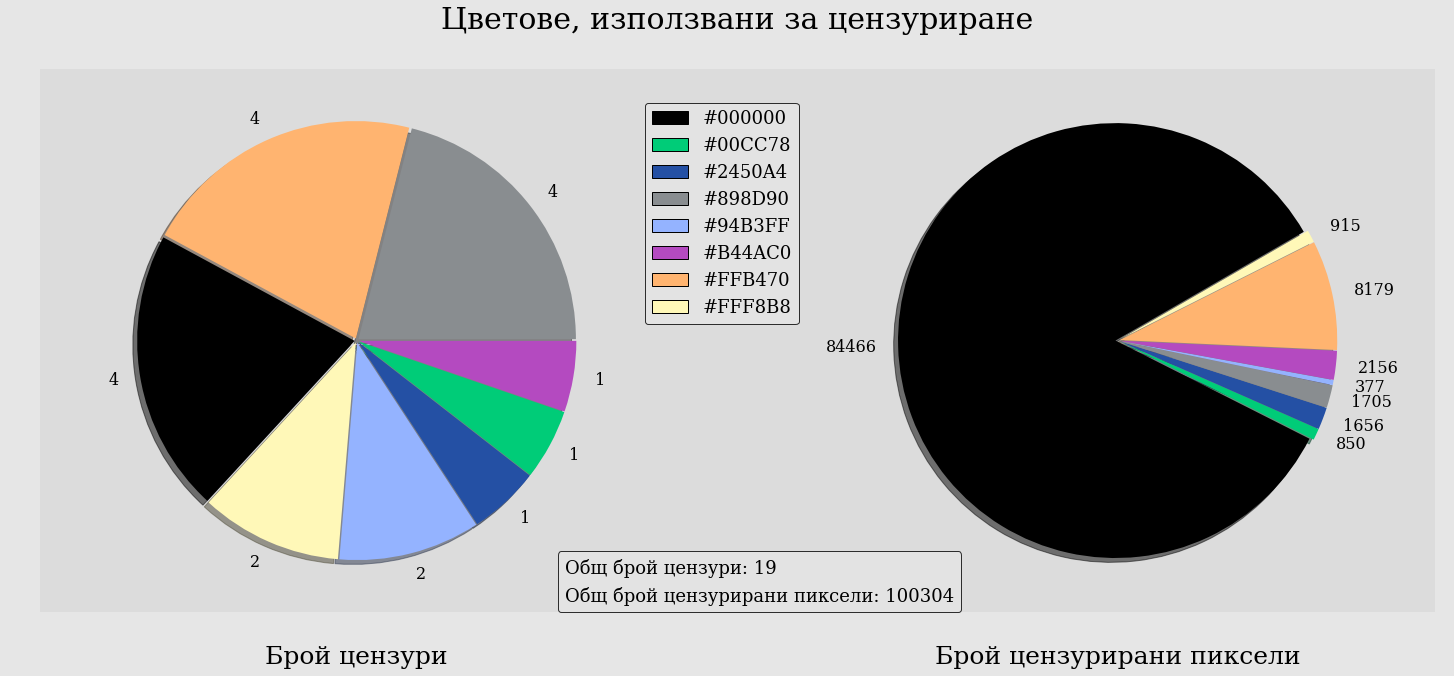

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)    
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='#E6E6E6', top=False, bottom=False, left=False, right=False)
ax.grid(False)

ax.set_title('Цветове, използвани за цензуриране')

color_pie = []
for color_num in moderated_count.iteritems():
    color_pie.append(color_num[0])

labels_pie = []
for count in moderated_count.iteritems():
    labels_pie.append(count[1])

explode_pie = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

moderated_count.plot(kind='pie', colors=color_pie, labels=labels_pie, explode=explode_pie, ax=ax1, shadow=True)

ax1.set_xlabel('Брой цензури')
ax1.set_ylabel('')

color_pie = []
for color_num in num_moderated_pixels.iteritems():
    color_pie.append(color_num[0])

labels_pie = []
for count in num_moderated_pixels.iteritems():
    labels_pie.append(count[1])

num_moderated_pixels.plot(kind='pie', colors=color_pie, labels=labels_pie, explode=explode_pie, ax=ax2, startangle=30, shadow=True)

ax2.set_xlabel('Брой цензурирани пиксели')
ax2.set_ylabel('')

leg = ax1.legend(labels=color_pie, loc=(1.03,0.53), prop={'size' : 18}, facecolor='#E6E6E6', edgecolor='black')
for i in range(0,len(color_pie)):
    leg.legendHandles[i].set_color(color_pie[i]) 
    leg.legendHandles[i].set_edgecolor('black')

custom_text = [f'Общ брой цензури: {moderated_count.sum()}', f'Общ брой цензурирани пиксели: {num_moderated_pixels.sum()}']
custom_label = ax2.legend(labels=custom_text, loc=(-0.53,0), handlelength=0, handletextpad=0, fancybox=True, prop=dict(size=18), facecolor='#E6E6E6', edgecolor='black')
for item in custom_label.legendHandles:
    item.set_visible(False)

In [46]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig.savefig(f'output\\plot_moderated-{now}.png')

In [85]:
ddf_moderated = ddf_moderated.rename(columns={'timestamp': 'Дата и час (UTC)', 'pixel_color': 'Цвят (hex)', 'num_pixels': 'Брой пиксели'})

ddf_moderated.head()

,Дата и час (UTC),Цвят (hex),x1,y1,x2,y2,Брой пиксели
0,2022-04-01 14:44:07,#898D90,862,540,868,544,24
1,2022-04-01 14:46:23,#898D90,862,540,873,545,55
2,2022-04-01 14:46:39,#898D90,871,546,878,550,28
3,2022-04-03 23:03:29,#FFB470,298,1770,334,1803,1188
4,2022-04-03 23:05:04,#FFB470,298,1805,329,1839,1054


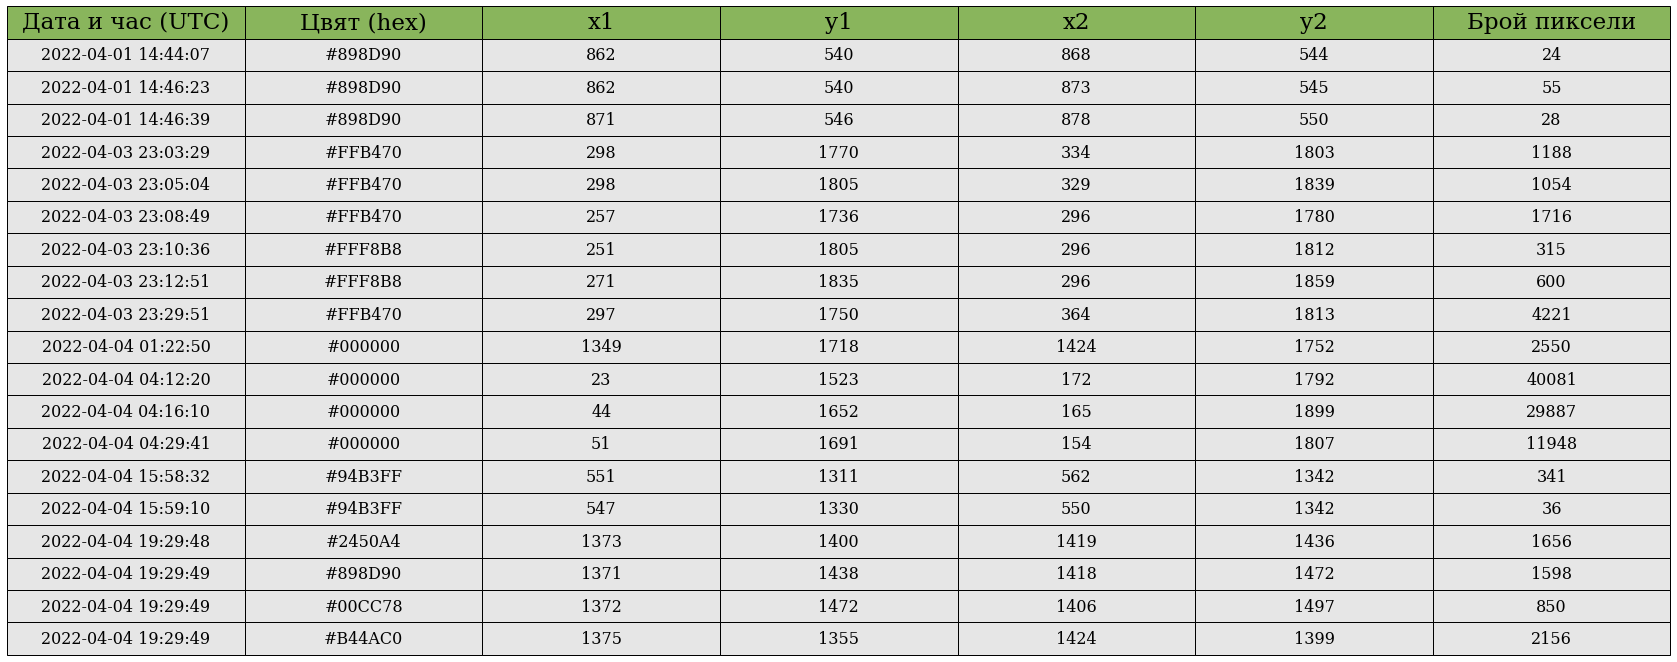

In [86]:
fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

cell_colors = [['' for x in range(len(ddf_moderated.columns))] for y in range(len(ddf_moderated))]
for row in range(0,len(cell_colors)):
    for col in range(0,len(cell_colors[0])):
        cell_colors[row][col] = '#E6E6E6'

col_colors = []
col_widths = []
for col in range(0,len(ddf_moderated.columns)):
    col_colors.append('#89b55c')
    col_widths.append(0.2)


table = ax.table(cellText=ddf_moderated.values, colLabels=ddf_moderated.columns, loc='center', cellColours=cell_colors, colColours=col_colors, colWidths=col_widths, cellLoc='center')
table.scale(1,3)
table.auto_set_font_size(False)
table.set_fontsize(16)

for (row, col), cell in table.get_celld().items():
  if (row == 0):
    cell.set_text_props(fontproperties=FontProperties(size=23))

fig.tight_layout()

In [87]:
if SAVE_FILES:
    now = datetime.now().strftime('%d%H%M')

    fig.savefig(f'output\\table_moderated-{now}.png')

# Анимирани диаграми

In [50]:
date_format = '%H:%M %d-%m-%Y'

bars_cmap = ['#000000', '#00A368', '#2450A4', '#3690EA', '#51E9F4', '#7EED56', '#811E9F', '#898D90', '#9C6926', '#B44AC0', '#D4D7D9', '#FF4500', '#FF99AA', '#FFA800', '#FFD635', '#FFFFFF', '#00756F', '#009EAA', '#00CC78', '#493AC1', '#6A5CFF', '#6D482F', '#BE0039', '#FF3881', '#00CCC0', '#515252', '#6D001A', '#94B3FF', '#DE107F', '#E4ABFF', '#FFB470', '#FFF8B8']
fixed_bars_cmap = ['#000000', '#FFFFFF', '#FF4500', '#2450A4', '#FFD635', '#BE0039', '#51E9F4', '#811E9F', '#FFA800', '#FF99AA', '#3690EA', '#00A368', '#898D90', '#7EED56', '#D4D7D9', '#9C6926', '#FFB470', '#FF3881', '#B44AC0', '#6D482F', '#00CC78', '#493AC1', '#FFF8B8', '#515252', '#6D001A', '#DE107F', '#00756F', '#6A5CFF', '#94B3FF', '#009EAA', '#E4ABFF', '#00CCC0']

### Анимирана диаграма, показваща броя поставени пиксели за всеки час

In [51]:
ddf_date['datetime'] = dd.to_datetime(ddf_date['datetime'])
ddf_date.dtypes

datetime    datetime64[ns]
dtype: object

In [52]:
ddf_datecount = ddf_date.datetime.value_counts('datetime').compute()
ddf_datecount.head()

2022-04-04 21:00:00    5901646
2022-04-04 22:00:00    5640455
2022-04-04 20:00:00    4904479
2022-04-04 19:00:00    4567933
2022-04-03 21:00:00    4480088
Name: datetime, dtype: int64

In [53]:
ddf_datecount = ddf_datecount.reset_index(name='num_placed_pixels').sort_values('index').set_index('index')
ddf_datecount.head()

,num_placed_pixels
index,
2022-04-01 12:00:00,19
2022-04-01 13:00:00,548836
2022-04-01 14:00:00,867847
2022-04-01 15:00:00,996924
2022-04-01 16:00:00,1070919


In [54]:
if SAVE_FILES:
    fig = plt.figure()
    ax = plt.axes()

    ax.set_title('Брой поставени пиксели за всеки час')
    ax.set_xlabel('Дата и час (UTC)')
    ax.set_ylabel('Брой поставени пиксели (милиони)')

    ax.get_yaxis().get_major_formatter().set_scientific(False)

    now = datetime.now().strftime('%d%H%M')

    ddf_datecount.plot_animated(filename=f'output\\animated_activity-{now}.gif', 
        fig=fig, 
        add_legend=False, 
        kind='line', 
        linewidth=5,
        figsize=(25,10),
        period_fmt=date_format,
        period_label=False,
        tick_label_size=16,
        label_events={    
            '  Първи ден': datetime.strptime('00:00 01-04-2022', date_format),
            '  Втори ден': datetime.strptime('00:00 02-04-2022', date_format),
            '  Трети ден': datetime.strptime('00:00 03-04-2022', date_format),
            '  Четвърти ден': datetime.strptime('00:00 04-04-2022', date_format)
        },
        antialiased=True,
        )

Generating LineChart, plotting ['num_placed_pixels']


### Анимирана диаграма, показваща кумулативния брой поставени пиксели

In [74]:
if SAVE_FILES:
    fig = plt.figure()
    ax = plt.axes()

    ax.set_title('Кумулативен брой поставени пиксели')
    ax.set_xlabel('Дата и час (UTC)')
    ax.set_ylabel('Брой поставени пиксели (милиони)')

    ax.yaxis.set_major_formatter(formatter)    

    now = datetime.now().strftime('%d%H%M')

    ddf_datecount.cumsum().plot_animated(filename=f'output\\animated_activity_cumsum-{now}.gif', 
        fig=fig, 
        add_legend=False, 
        kind='line', 
        figsize=(25,10),
        period_fmt=date_format,
        period_label=False,
        tick_label_size=16,
        label_events={    
            '  Първи ден': datetime.strptime('00:00 01-04-2022', date_format),
            '  Втори ден': datetime.strptime('00:00 02-04-2022', date_format),
            '  Трети ден': datetime.strptime('00:00 03-04-2022', date_format),
            '  Четвърти ден': datetime.strptime('00:00 04-04-2022', date_format)
        },
        fill_under_line_color='#89A3D5',
        antialiased=True
        )

Generating LineChart, plotting ['num_placed_pixels']


### Анимирана графика, показваща броя и вида поставевни цветове за всеки час

In [56]:
ddf_pivoted['datetime'] = dd.to_datetime(ddf_pivoted['datetime'])
ddf_pivoted = ddf_pivoted.set_index('datetime')

In [57]:
ddf_pivoted = ddf_pivoted.compute()
type(ddf_pivoted)

pandas.core.frame.DataFrame

In [78]:
if SAVE_FILES:
    fig = plt.figure()
    ax = plt.axes()

    ax.set_title('Брой поставени пиксели според цвета за всеки час')
    ax.set_ylabel('Цвят (hex)')
    ax.set_xlabel('Брой пиксели')

    now = datetime.now().strftime('%d%H%M')

    ddf_pivoted.plot_animated(filename=f'output\\animated_colors-{now}.gif',    
        period_length=700,
        bar_label_size=14,
        add_legend=False, 
        figsize=(25,10),
        fig=fig,
        period_fmt=date_format,
        fixed_order=fixed_bars_cmap,
        period_label=True,
        tick_label_size=14,
        cmap=fixed_bars_cmap,
        antialiased=True,
        fixed_max=True
        )

Generating BarChartRace, plotting ['#000000', '#FFFFFF', '#FF4500', '#2450A4', '#FFD635', '#BE0039', '#51E9F4', '#811E9F', '#FFA800', '#FF99AA', '#3690EA', '#00A368', '#898D90', '#7EED56', '#D4D7D9', '#9C6926', '#FFB470', '#FF3881', '#B44AC0', '#6D482F', '#00CC78', '#493AC1', '#FFF8B8', '#515252', '#6D001A', '#DE107F', '#00756F', '#6A5CFF', '#94B3FF', '#009EAA', '#E4ABFF', '#00CCC0']


c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas_alive\charts.py:68: UserWarning: Plotting too many bars may result in undesirable output, use `n_visible=15` to limit number of bars
  warnings.warn(
c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


### Анимирана графика, показваща кумумулативния брой поставени пиксели от всеки цвят

In [59]:
plt.rcParams['xtick.labelsize'] = 0

fig = plt.Figure()
gs = plt.GridSpec(1,2, width_ratios=[7,3])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

fig.suptitle('Кумумулативен брой поставени пиксели от всеки цвят')
ax1.set_ylabel('Цвят (hex)')
ax1.set_xlabel('Брой пиксели (милиони)')

formatter = FuncFormatter(millions)
ax1.xaxis.set_major_formatter(formatter)

now = datetime.now().strftime('%d%H%M')

bar_chart = ddf_pivoted.cumsum().plot_animated(   
    period_length=700,
    bar_label_size=14,
    add_legend=False, 
    figsize=(25,10),
    period_fmt=date_format,
    period_label=True,
    tick_label_size=14,
    cmap=bars_cmap,
    antialiased=True,
    )

bar_chart.ax = ax1

pie_chart = ddf_pivoted.cumsum().plot_animated(  
    kind='pie',
    figsize=(10,10),
    cmap=bars_cmap,
    )

pie_chart.ax = ax2

if SAVE_FILES:
    pandas_alive.animate_multiple_plots(f'output\\animated_colors_cumsum-{now}.gif', [bar_chart,pie_chart], fig)

Generating BarChartRace, plotting ['#000000', '#00A368', '#2450A4', '#3690EA', '#51E9F4', '#7EED56', '#811E9F', '#898D90', '#9C6926', '#B44AC0', '#D4D7D9', '#FF4500', '#FF99AA', '#FFA800', '#FFD635', '#FFFFFF', '#00756F', '#009EAA', '#00CC78', '#493AC1', '#6A5CFF', '#6D482F', '#BE0039', '#FF3881', '#00CCC0', '#515252', '#6D001A', '#94B3FF', '#DE107F', '#E4ABFF', '#FFB470', '#FFF8B8']


c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas_alive\charts.py:221: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df.columns)
c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas_alive\charts.py:222: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))
c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas_alive\charts.py:68: UserWarning: Plotting too many bars may result in undesirable output, use `n_visible=15` to limit number of bars
  warnings.warn(
c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas_alive\_base_chart.py:458: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df.columns)
c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas_alive\_base_chart.py:459: UserW

Generating PieChart, plotting ['#000000', '#00A368', '#2450A4', '#3690EA', '#51E9F4', '#7EED56', '#811E9F', '#898D90', '#9C6926', '#B44AC0', '#D4D7D9', '#FF4500', '#FF99AA', '#FFA800', '#FFD635', '#FFFFFF', '#00756F', '#009EAA', '#00CC78', '#493AC1', '#6A5CFF', '#6D482F', '#BE0039', '#FF3881', '#00CCC0', '#515252', '#6D001A', '#94B3FF', '#DE107F', '#E4ABFF', '#FFB470', '#FFF8B8']


c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [60]:
plt.style.use('style.mplstyle')

### Анимирана графика, показваща броя поставени пиксели в 5-те най-популярни точки за всеки час

In [61]:
ddf_top3_coords = dd.read_csv('data\\raw\\2022_place_canvas_history_core.csv')
ddf_top3_coords = ddf_top3_coords[(ddf_top3_coords['coordinate'] == '0,0') | (ddf_top3_coords['coordinate'] == '359,564') | (ddf_top3_coords['coordinate'] == '349,564') | (ddf_top3_coords['coordinate'] == '859,766') | (ddf_top3_coords['coordinate'] == '860,766')]
ddf_top3_coords = ddf_top3_coords.drop('pixel_color', axis=1)

ddf_top3_coords.head()

,timestamp,coordinate
10,169219,"0,0"
59,1184423,"0,0"
62,1184622,"0,0"
158,1192817,"0,0"
902,1221457,"0,0"


In [62]:
ddf_top3_coords['index'] = ddf_top3_coords.reset_index().index
ddf_top3_coords['timestamp'] = ddf_top3_coords.apply(lambda x: parse_timestamp(x['timestamp'], '%Y-%m-%d %H'), axis=1)
ddf_top3_coords = ddf_top3_coords.rename(columns={'timestamp': 'datetime'})

ddf_top3_coords.head()

c:\Users\Denis\AppData\Local\Programs\Python\Python38\lib\site-packages\dask\dataframe\core.py:5408: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'datetime64[ns]'))

  warnings.warn(meta_warning(meta))


,datetime,coordinate,index
10,2022-04-01 12:00:00,"0,0",0
59,2022-04-01 13:00:00,"0,0",1
62,2022-04-01 13:00:00,"0,0",2
158,2022-04-01 13:00:00,"0,0",3
902,2022-04-01 13:00:00,"0,0",4


In [63]:
ddf_top3_coords['coordinate'] = ddf_top3_coords['coordinate'].astype('category')
ddf_top3_coords['coordinate'] = ddf_top3_coords.coordinate.cat.as_known()

ddf_top3_coords.dtypes

datetime      datetime64[ns]
coordinate          category
index                  int64
dtype: object

In [64]:
ddf_top3_coords = ddf_top3_coords.pivot_table(index='datetime', columns='coordinate', values='coordinate', aggfunc='count')
ddf_top3_coords = ddf_top3_coords.compute()

ddf_top3_coords.head()

coordinate,"0,0","349,564","359,564","859,766","860,766"
datetime,,,,,
2022-04-01 12:00:00,1.0,0.0,0.0,0.0,0.0
2022-04-01 13:00:00,777.0,1.0,1.0,0.0,2.0
2022-04-01 14:00:00,705.0,0.0,0.0,751.0,670.0
2022-04-01 15:00:00,811.0,0.0,0.0,1759.0,1635.0
2022-04-01 16:00:00,1198.0,484.0,573.0,1601.0,1598.0


In [65]:
if SAVE_FILES:
    fig = plt.figure()
    ax = plt.axes()

    ax.set_title('Брой поставени пиксели за всеки час в 5-те най-популярни точки')
    ax.set_xlabel('Дата и час (UTC)')
    ax.set_ylabel('Брой пиксели')

    now = datetime.now().strftime('%d%H%M')

    ddf_top3_coords.plot_animated(filename=f'output\\animated_top5_coords-{now}.gif', 
        fig=fig, 
        add_legend=True, 
        linewidth=5,
        kind='line', 
        figsize=(25,10),
        period_fmt=date_format,
        period_label=False,
        tick_label_size=16,
        label_events={    
            '  Първи ден': datetime.strptime('00:00 01-04-2022', date_format),
            '  Втори ден': datetime.strptime('00:00 02-04-2022', date_format),
            '  Трети ден': datetime.strptime('00:00 03-04-2022', date_format),
            '  Четвърти ден': datetime.strptime('00:00 04-04-2022', date_format)
        },
        antialiased=True
        )

Generating LineChart, plotting ['0,0', '349,564', '359,564', '859,766', '860,766']
